Author: Ond\v{r}ej Podsztavek

# Introduction

This project address the problem of hyperparameter optimization or model selection problem with Kolomogorov Complexity. It is focused determining the best number of [K-means](https://cs.wikipedia.org/wiki/K-means) clusters using the minimum description length principle.

## Minimum Description Length Principle (MDL)

The best theory to describe observed data is the one which minimizes the sum of the description length (in bits) of:

- the theory description,
- the data encoded from the theory,

MDL is provided by formula:

$$\hat{H} = \arg \min_{H_i} \{C(H_i) + C(D|H_i)\},$$

where $\hat{H}$ is the optimal theory, $C(\cdot)$ computes description complexity, $H_i$ are proposed theories and $D$ are the data to be encoded from the theories.

## Unsupervised Learning

Unsupervised learning is in some sense compression. In both clustering and anomaly detection the problem is to find structure in given data, but finding structure means compressing the description of data.

The aim of this project is to predict the best number of clusters in a data using MDL. Given decision function $h: \mathcal{X} \to \mathcal{Y}$ (k-means), where $\mathcal{X}$ and $\mathcal{Y}$ are input and output space respectively, and $\mathcal{D}_S = \{(x_1, y_1), \dots, (x_n, y_n)\}$ is training set. A $\hat{h}$ decision function should be found (k-means number of clusters and positions) such that:

$$\hat{h} = \arg \min_{h} \{C(h) + C(\mathcal{D}_S|h)\}.$$

The problem is that $C(\cdot)$ is not computable. Therefore robust approximation need to be found.

## Proposed Approach

This project approximate description complexity of $C(\mathcal{D}_S|h)\}$ as complexity of locations to landmarks. Each data point $x_i$ complexity is given as distance to the nearest cluster center $\mu_j$:

$$C(\mu_j) + d \log(\text{distance}(\mu_j, x_j)),$$

where $C(\mu_i)$ may be assessed by $\log(i)$ and $d$ is number of dimensions of the feature space.

The description complexity of model $C(h)$ is approximated the memory usage in bits of all the cluster center coordinates as `numpy.float16` data type.

# Experiments

All experiments were carried out on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris). K-means clustering algorithm was run on the dataset with different number of clusters and complexity was calculated according to formulas in previous section. Figure 1 shows the results.

![Figure 1: Complexity dependence on number of clusters](complexity_16.pdf)

![Figure 2: Complexities when representing model with 32 bits float numbers](complexity_32.pdf)

In [1]:
import numpy
from matplotlib import pyplot
from sklearn import datasets, cluster, metrics, preprocessing

In [2]:
%matplotlib inline

In [3]:
iris = datasets.load_iris()
X = iris.data
labels = numpy.unique(iris.target)
n_features = X.shape[1]
labels, n_features

(array([0, 1, 2]), 4)

In [4]:
def calculate_complexities(X, max_clusters=20):
    ks = numpy.arange(1, 12)
    complexities = numpy.zeros((len(ks), 2))

    for k in ks:
        # TODO the random_state?
        kmeans = cluster.KMeans(n_clusters=k, random_state=0)
        # fit the model
        kmeans.fit(X)
        # compute the distances to cluster centers
        distances = metrics.pairwise.euclidean_distances(X, kmeans.cluster_centers_)
        # get the only distances to nearest cluster center
        shortest_distances = distances[numpy.arange(len(distances)), kmeans.labels_]
        
        # approximate the complexity by distance to nearest cluster center
        points_complexity = numpy.sum(numpy.log1p(kmeans.labels_) + n_features * numpy.log1p(shortest_distances))
        
        # calculate the model complexity
        model_complexity = kmeans.cluster_centers_.astype(numpy.float16).nbytes * 8
        
        complexities[k - 1] = [points_complexity, model_complexity]

    return ks, complexities

ks, complexities = calculate_complexities(X)
for k, (points_complexity, model_complexity) in zip(ks, complexities):
    print(k, '\t', points_complexity, '\t', model_complexity, '\t', points_complexity + model_complexity)

1 	 617.861463986 	 64.0 	 681.861463986
2 	 416.189958155 	 128.0 	 544.189958155
3 	 365.520292505 	 192.0 	 557.520292505
4 	 383.075359567 	 256.0 	 639.075359567
5 	 362.681942525 	 320.0 	 682.681942525
6 	 388.617381272 	 384.0 	 772.617381272
7 	 385.594904863 	 448.0 	 833.594904863
8 	 398.398778102 	 512.0 	 910.398778102
9 	 418.749878553 	 576.0 	 994.749878553
10 	 391.71548128 	 640.0 	 1031.71548128
11 	 411.664376862 	 704.0 	 1115.66437686


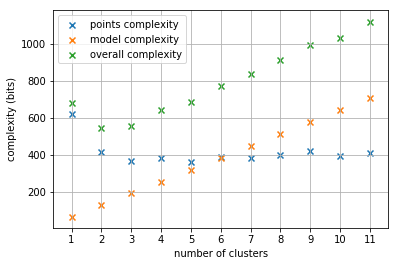

In [5]:
def plot_complexities(ks, complexities):
    pyplot.scatter(ks, complexities[:, 0], marker='x', label='points complexity')
    pyplot.scatter(ks, complexities[:, 1], marker='x', label='model complexity')
    pyplot.scatter(ks, numpy.sum(complexities, axis=1), marker='x', label='overall complexity')
    pyplot.xticks(ks)
    pyplot.legend()
    pyplot.grid(True)
    pyplot.xlabel('number of clusters')
    pyplot.ylabel('complexity (bits)')

plot_complexities(ks, complexities)

pyplot.savefig('complexity_16.pdf')

From this experiment is obvious that this approach is not able to find optimal number of clusters because there are 3 classes in Iris dataset. The main problem is that it depends on the data type used from model representation. In figure 2 `numpy.float32` was used and the result completely follows the problem.

# Conclusion

In conclusion, it might be concluded that the approach proposed in this project is not robust approximation and depends on model representation. But it is close to actual optimal value of clusters. On the other hand this area is great opportunity for other studies as it would provide intuitive and simple formula for model selection or hyperparameter optimization if robust approximation of description complexity can be found.